In [7]:
!pip3 install colour

In [8]:
import bagpy
import folium
import pandas as pd
from bagpy import bagreader
from geopy.distance import geodesic
from IPython.display import HTML, display
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns
from colour import Color
%matplotlib notebook
pd.set_option("display.precision", 12)
#
# Author: Nathaniel Hanson
# Date: 02/16/2021
# Purpose: Stationary GPS Data Analysis
#

In [11]:
!pwd

/home/pingpongrobot/eece5554_roboticssensing/LAB1/src


In [13]:
### Stationary Data Analysis
bagFile = '../../../Downloads/bike_2.bag'
stationary = bagreader(bagFile)
# Show topic in bag files
print(stationary.topic_table)
# Convert topics to a Pandas data frame
dataStat = pd.read_csv(stationary.message_by_topic('/gps_data'))

[INFO]  Successfully created the data folder ../../../Downloads/bike_2.
                                              Topics  \
0  /cam1/aligned_depth_to_color/image_raw/compressed   
1                   /cam1/color/image_raw/compressed   
2  /cam2/aligned_depth_to_color/image_raw/compressed   
3                   /cam2/color/image_raw/compressed   
4                                          /gps_data   
5                                          /raw_data   

                         Types  Message Count        Frequency  
0  sensor_msgs/CompressedImage           9635  14.967362523641  
1  sensor_msgs/CompressedImage           9950  14.935809872446  
2  sensor_msgs/CompressedImage           9467  14.916952666826  
3  sensor_msgs/CompressedImage           9757  14.918570922989  
4               gps_driver/GPS            546   0.999767357602  
5              std_msgs/String           2408   6.132301317750  


In [22]:
# Plot locations on a map
m = folium.Map(
    location=[42.351944, -71.077415],
    max_zoom=20,
    zoom_start=19
)
temp = dataStat.apply(lambda row:folium.CircleMarker(location=[row["lat"], 
                                                  row["lon"]], radius=1).add_to(m),
         axis=1)
display(m)

In [9]:
# Calculate distance from true location to all points
dataStat['error_loc'] = dataStat.apply(
    lambda row: geodesic([row['lat'], row['lon']], true_loc).meters,
    axis = 1)
# True altitude determined from
# https://en-us.topographic-map.com/maps/f02f/Boston/
true_alt = 6.7056 # meters
true_utm = [328901.81, 4690968.93]
dataStat['error_abs'] = dataStat.apply(
    lambda row: np.sqrt(np.sum(
        (np.array([row['utm_easting'], row['utm_northing']]) - 
        np.array(true_utm))**2)),
    axis = 1)
dataStat['error_precision'] = dataStat.apply(
    lambda row: np.sqrt(np.sum(
        (np.array([row['utm_easting'], row['utm_northing']]) - 
        np.array(list(dataStat.mean()[['utm_easting','utm_northing']])))**2)),
    axis = 1)
dataStat['error_east'] = dataStat.apply(
    lambda row: np.sqrt(
        (row['utm_easting']-true_utm[0])**2),
    axis = 1)
dataStat['error_north'] = dataStat.apply(
    lambda row: np.sqrt(
        (row['utm_northing']-true_utm[1])**2),
    axis = 1)
dataStat['error_alt'] = dataStat.apply(
    lambda row: np.sqrt(
        (row['altitude']-true_alt)**2),
    axis = 1)
dataStat['time_elapsed'] =dataStat.apply(
    lambda row: (row['header.stamp.secs'] - dataStat.min()['header.stamp.secs'])*10,
    axis = 1
)

<IPython.core.display.Javascript object>


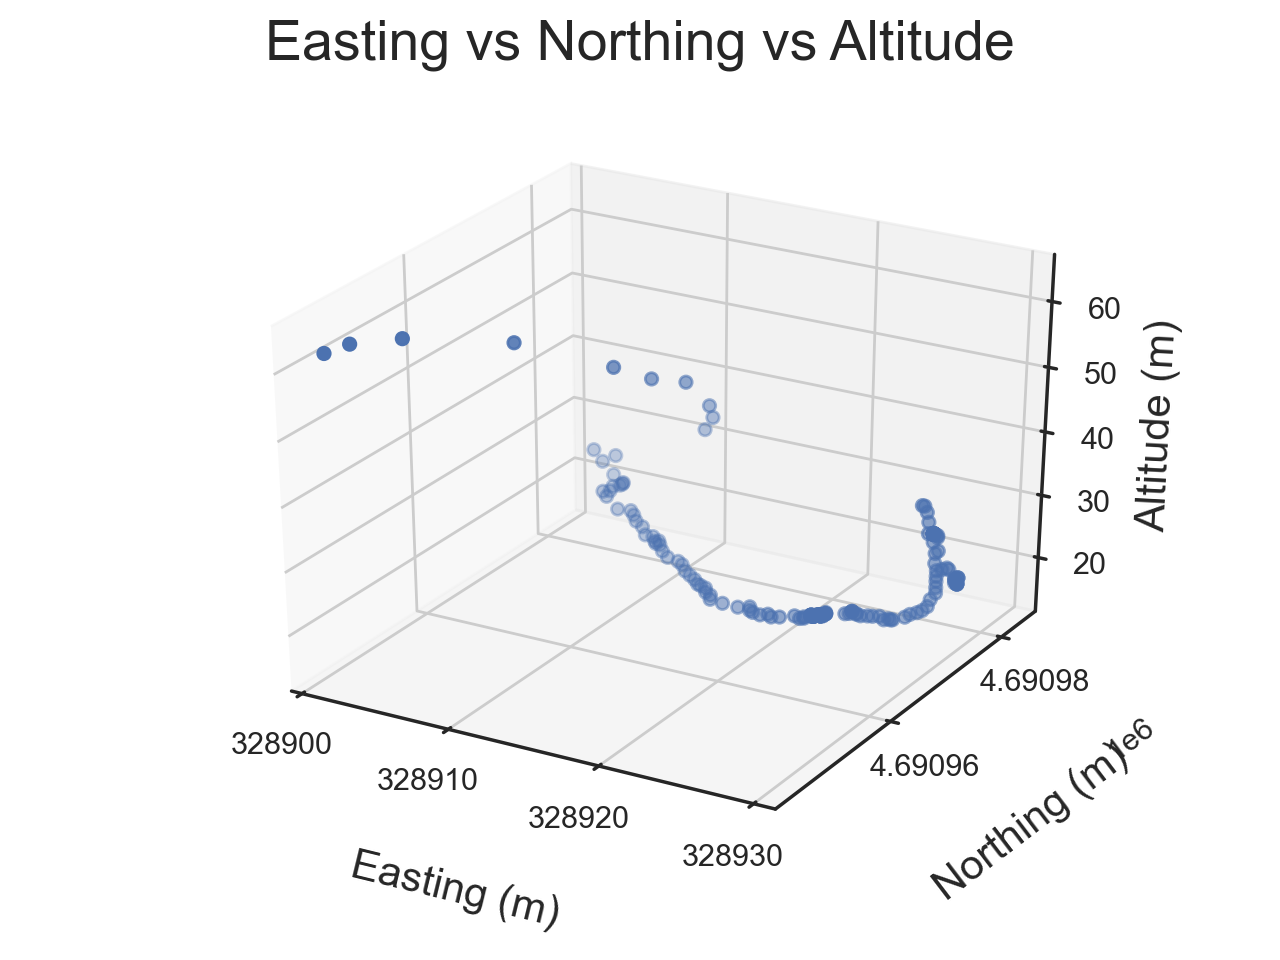

<IPython.core.display.Javascript object>


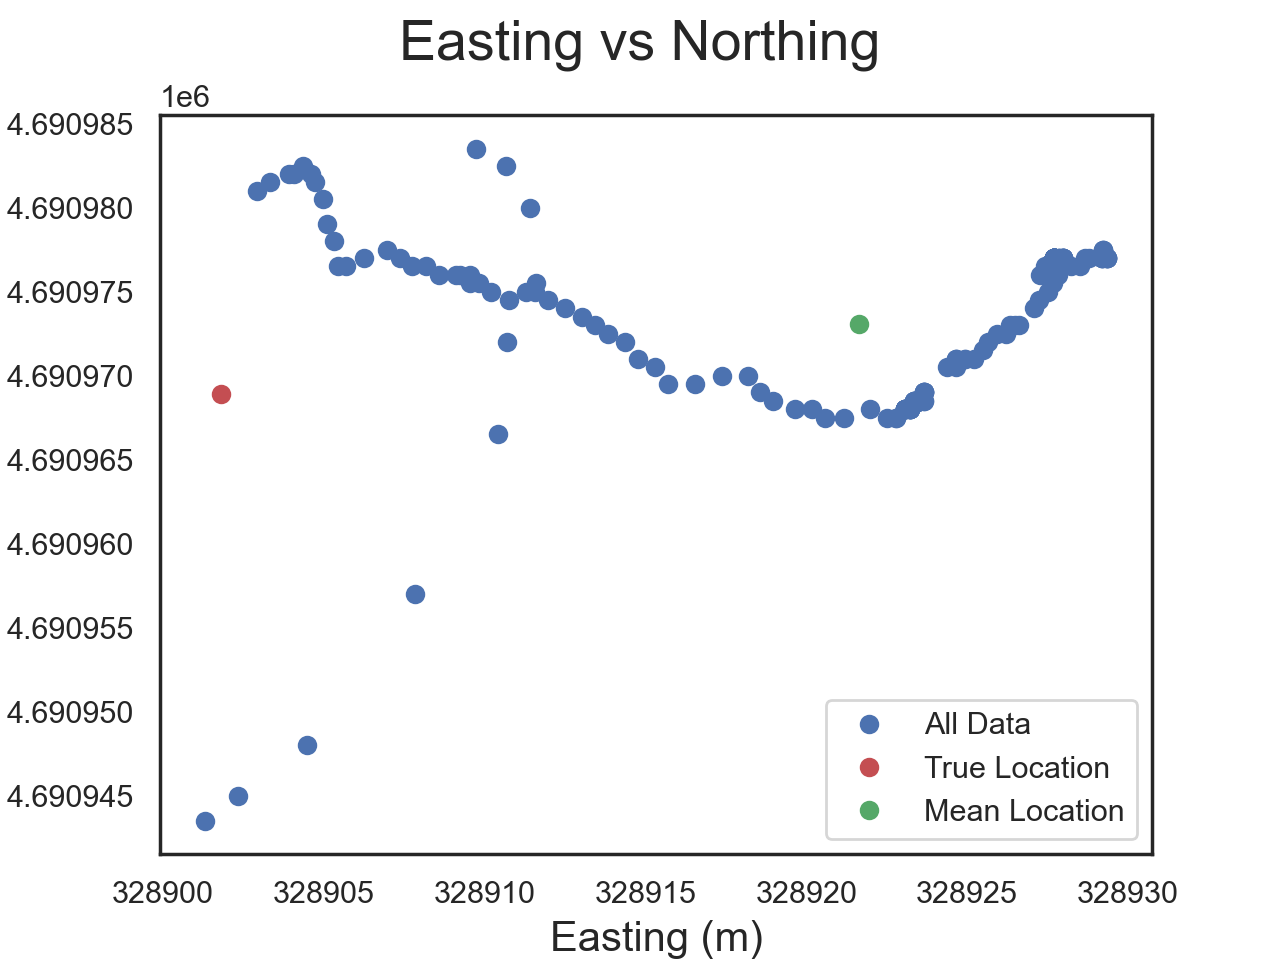

In [81]:
# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')

# Surface plot data
x = dataStat['utm_easting']
y = dataStat['utm_northing']
z = dataStat['altitude']

surf = ax.scatter(x,y,z)
# title and labels, setting initial sizes
fig.suptitle('Easting vs Northing vs Altitude', fontsize=20)
ax.set_xlabel('Easting (m)', fontsize=15, labelpad = 20)
ax.set_ylabel('Northing (m)', fontsize=15, labelpad = 20)
ax.set_zlabel('Altitude (m)', fontsize=15)
ax.ticklabel_format(useOffset=False)
plt.locator_params(axis="y", nbins=4)
plt.locator_params(axis="x", nbins=4)

# Location over time in two deimensions
fig2 = plt.figure()
ax2 = fig2.gca()
plt.plot(dataStat['utm_easting'], dataStat['utm_northing'], 'bo', label='All Data')
plt.plot(true_utm[0], true_utm[1], 'ro', label='True Location')
plt.plot(dataStat['utm_easting'].mean(), dataStat['utm_northing'].mean(), 'go', label='Mean Location')
fig2.suptitle('Easting vs Northing', fontsize=20)
ax2.set_xlabel('Easting (m)', fontsize=15)
ax2.set_ylabel('Northing (m)', fontsize=15, labelpad=20)
ax2.ticklabel_format(useOffset=False)
ax2.legend()

<IPython.core.display.Javascript object>


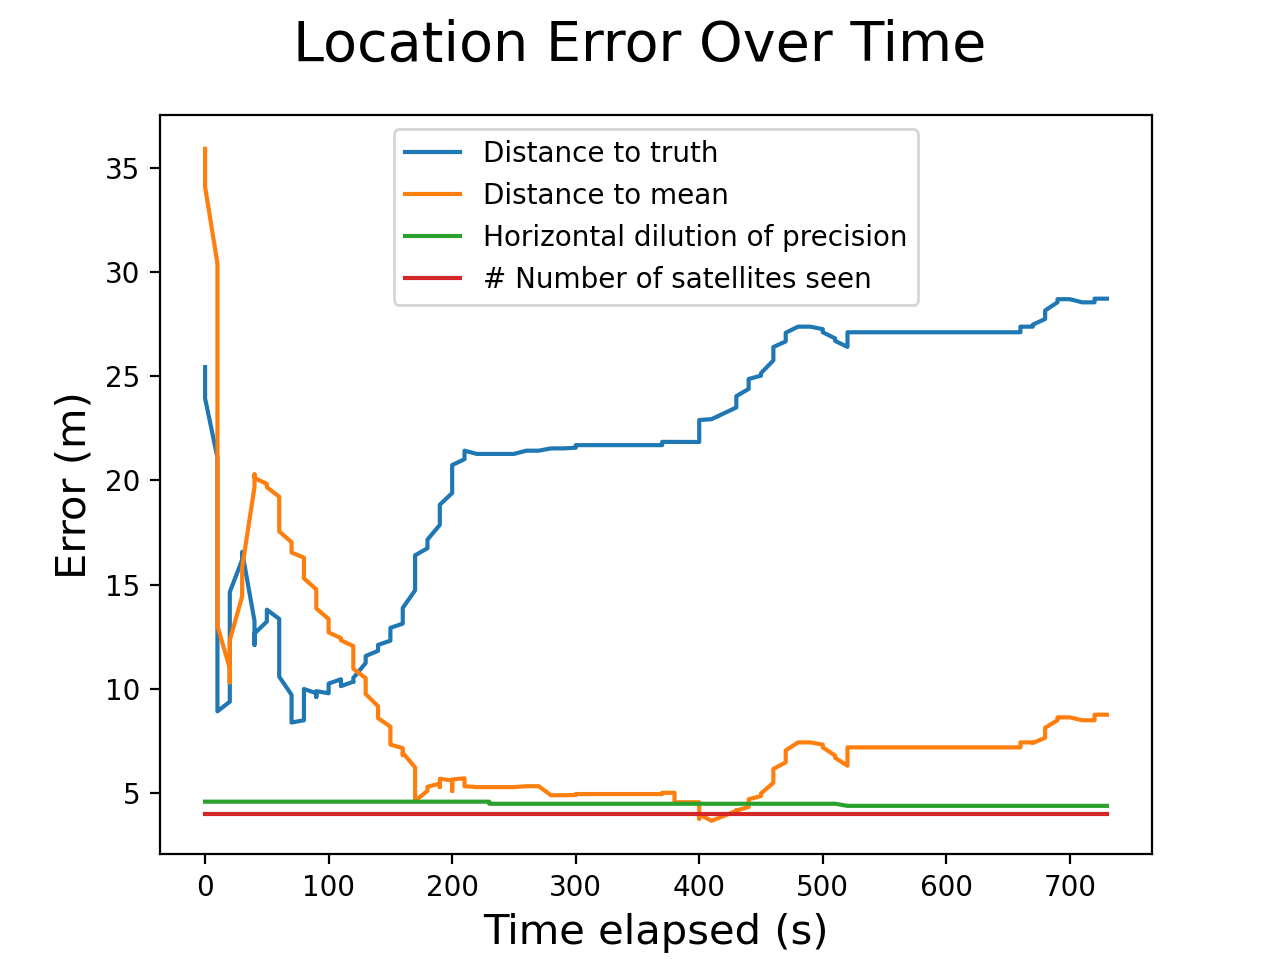

<IPython.core.display.Javascript object>


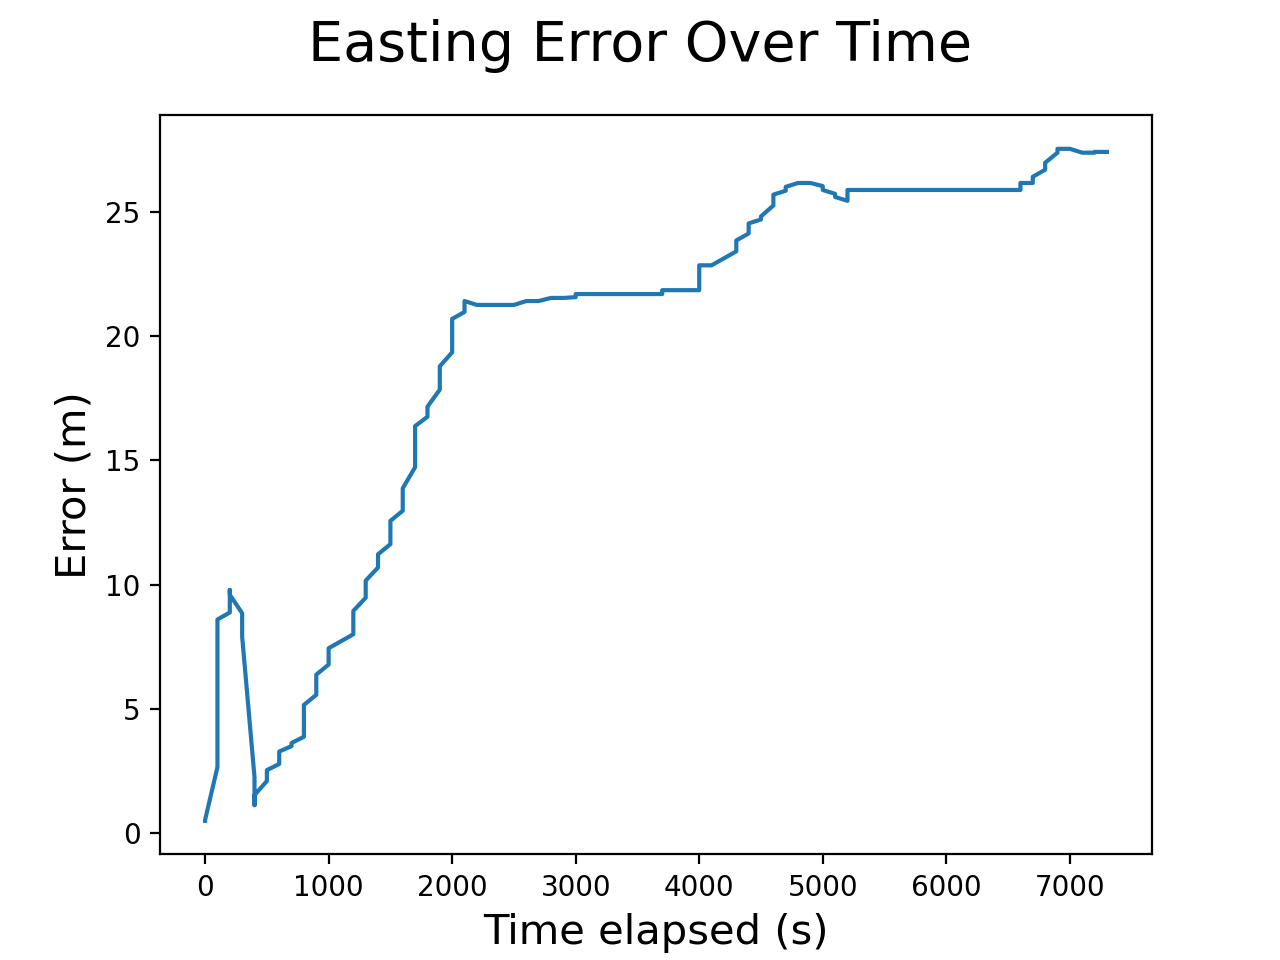

<IPython.core.display.Javascript object>


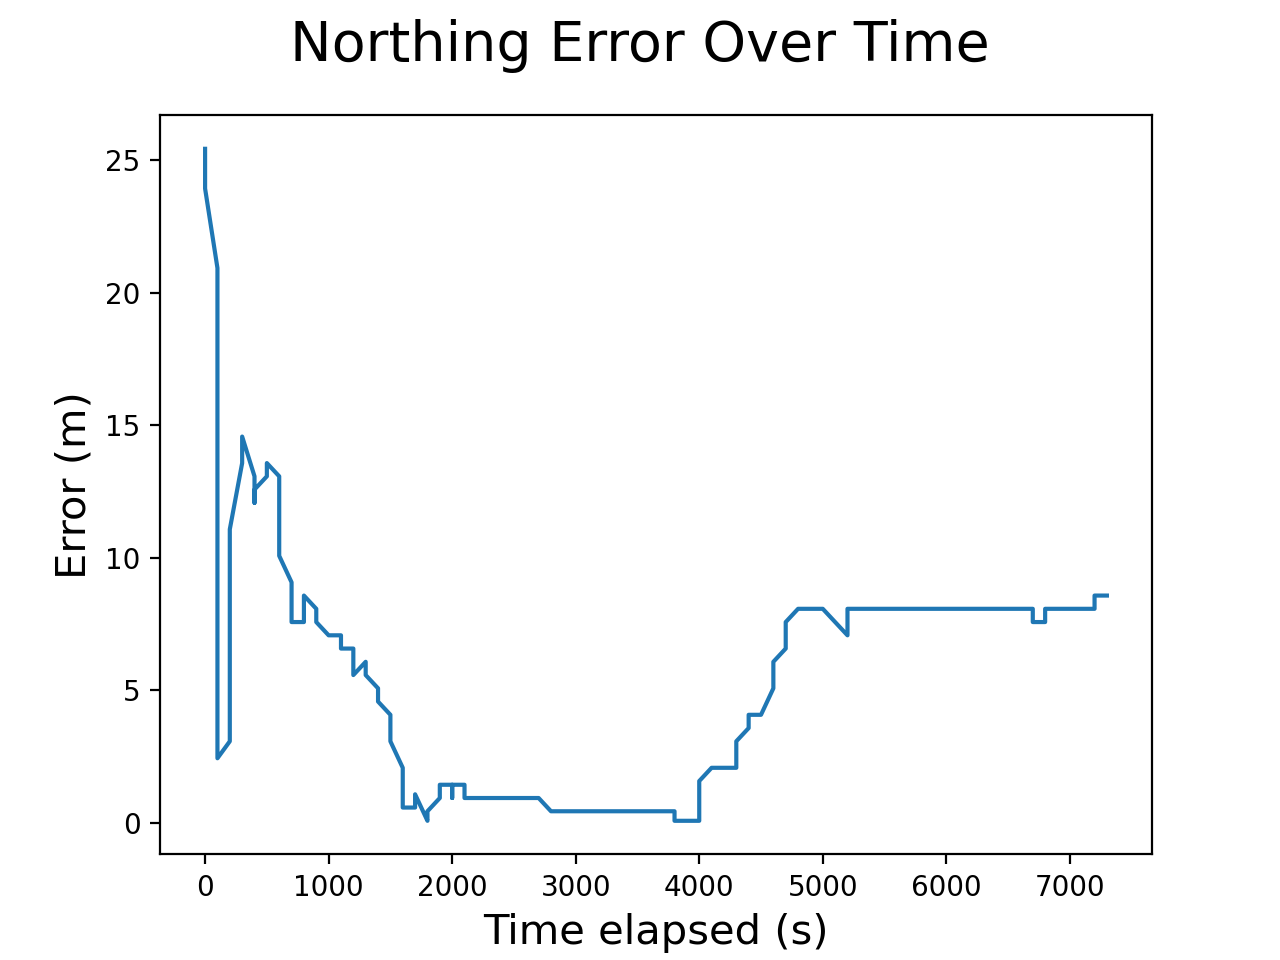

In [10]:
### Plot progressive error measurements over time

# Seeks to answer the question, is our error increasing or decreasing?
# Or following some unknown stochastic process
# Location error over time
fig2 = plt.figure()
ax2 = fig2.gca()
plt.plot(dataStat['time_elapsed'], dataStat['error_abs'], label='Distance to truth')
plt.plot(dataStat['time_elapsed'], dataStat['error_precision'], label='Distance to mean')
plt.plot(dataStat['time_elapsed'], dataStat['hdop'], label='Horizontal dilution of precision')
plt.plot(dataStat['time_elapsed'], dataStat['num_sats'], label='# Number of satellites seen')
ax2.legend()
fig2.suptitle('Location Error Over Time', fontsize=20)
ax2.set_xlabel('Time elapsed (s)', fontsize=15)
ax2.set_ylabel('Error (m)', fontsize=15)
ax2.ticklabel_format(useOffset=False)
# Easting error over time
fig3 = plt.figure()
ax3 = fig3.gca()
plt.plot(dataStat['time_elapsed']*10, dataStat['error_east'])
fig3.suptitle('Easting Error Over Time', fontsize=20)
ax3.set_xlabel('Time elapsed (s)', fontsize=15)
ax3.set_ylabel('Error (m)', fontsize=15)
ax3.ticklabel_format(useOffset=False)
# Northing error over time
fig4 = plt.figure()
ax4 = fig4.gca()
plt.plot(dataStat['time_elapsed']*10, dataStat['error_north'])
fig4.suptitle('Northing Error Over Time', fontsize=20)
ax4.set_xlabel('Time elapsed (s)', fontsize=15)
ax4.set_ylabel('Error (m)', fontsize=15)
ax4.ticklabel_format(useOffset=False)

<IPython.core.display.Javascript object>


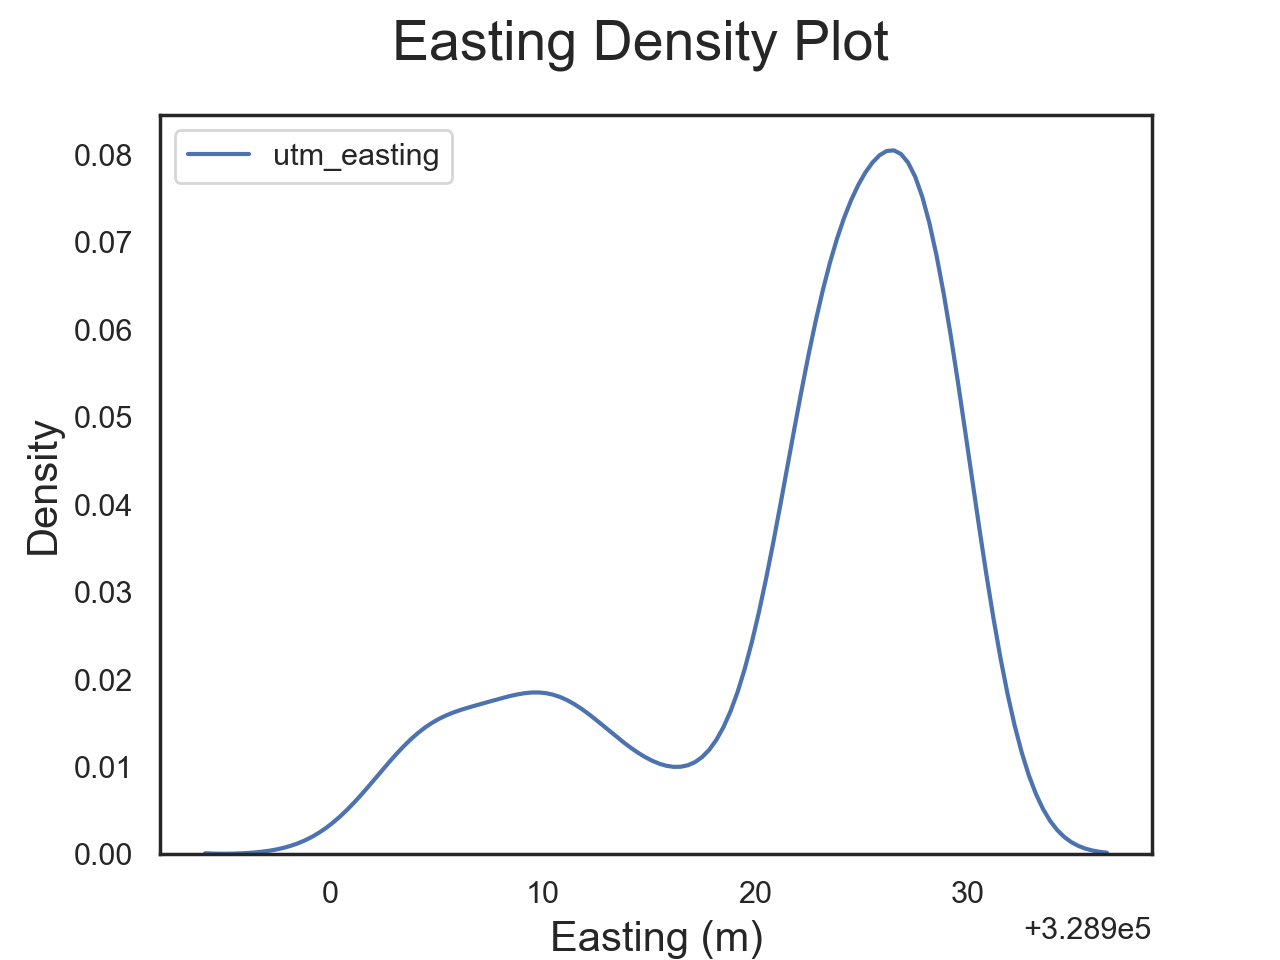

<IPython.core.display.Javascript object>


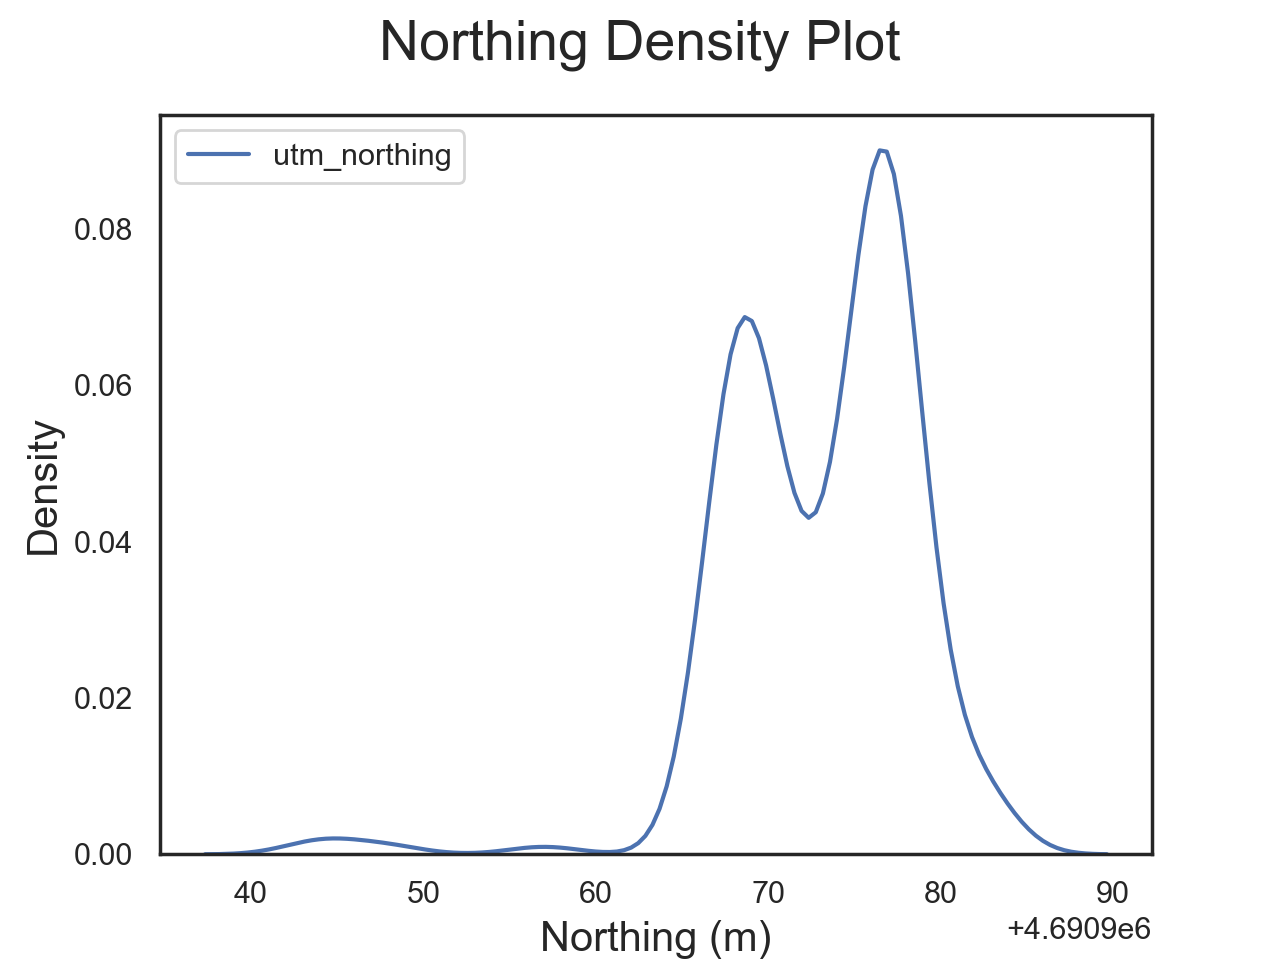

<IPython.core.display.Javascript object>


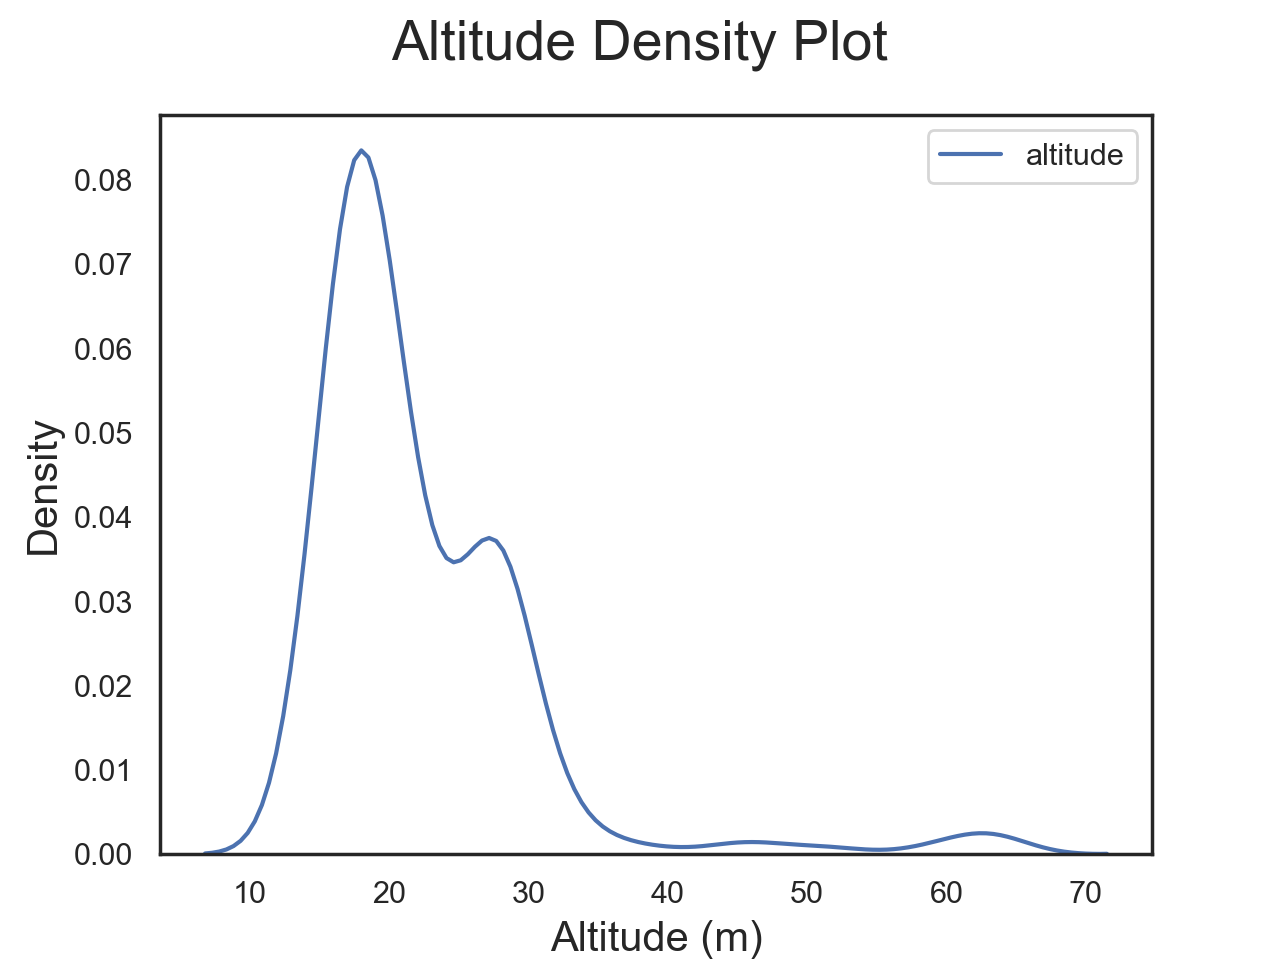

Text(0, 0.5, 'Density')

In [133]:
# Location point distribution over time
# Easting
fig2 = plt.figure()
ax2 = fig2.gca()
sns.kdeplot(dataStat['utm_easting'])
fig2.suptitle('Easting Density Plot', fontsize=20)
ax2.set_xlabel('Easting (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15) 
fig2 = plt.figure()
ax2 = fig2.gca()
# Northing
sns.kdeplot(dataStat['utm_northing'])
fig2.suptitle('Northing Density Plot', fontsize=20)
ax2.set_xlabel('Northing (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15) 
fig2 = plt.figure()
ax2 = fig2.gca()
# Altitude
sns.kdeplot(dataStat['altitude'])
fig2.suptitle('Altitude Density Plot', fontsize=20)
ax2.set_xlabel('Altitude (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15) 

<IPython.core.display.Javascript object>


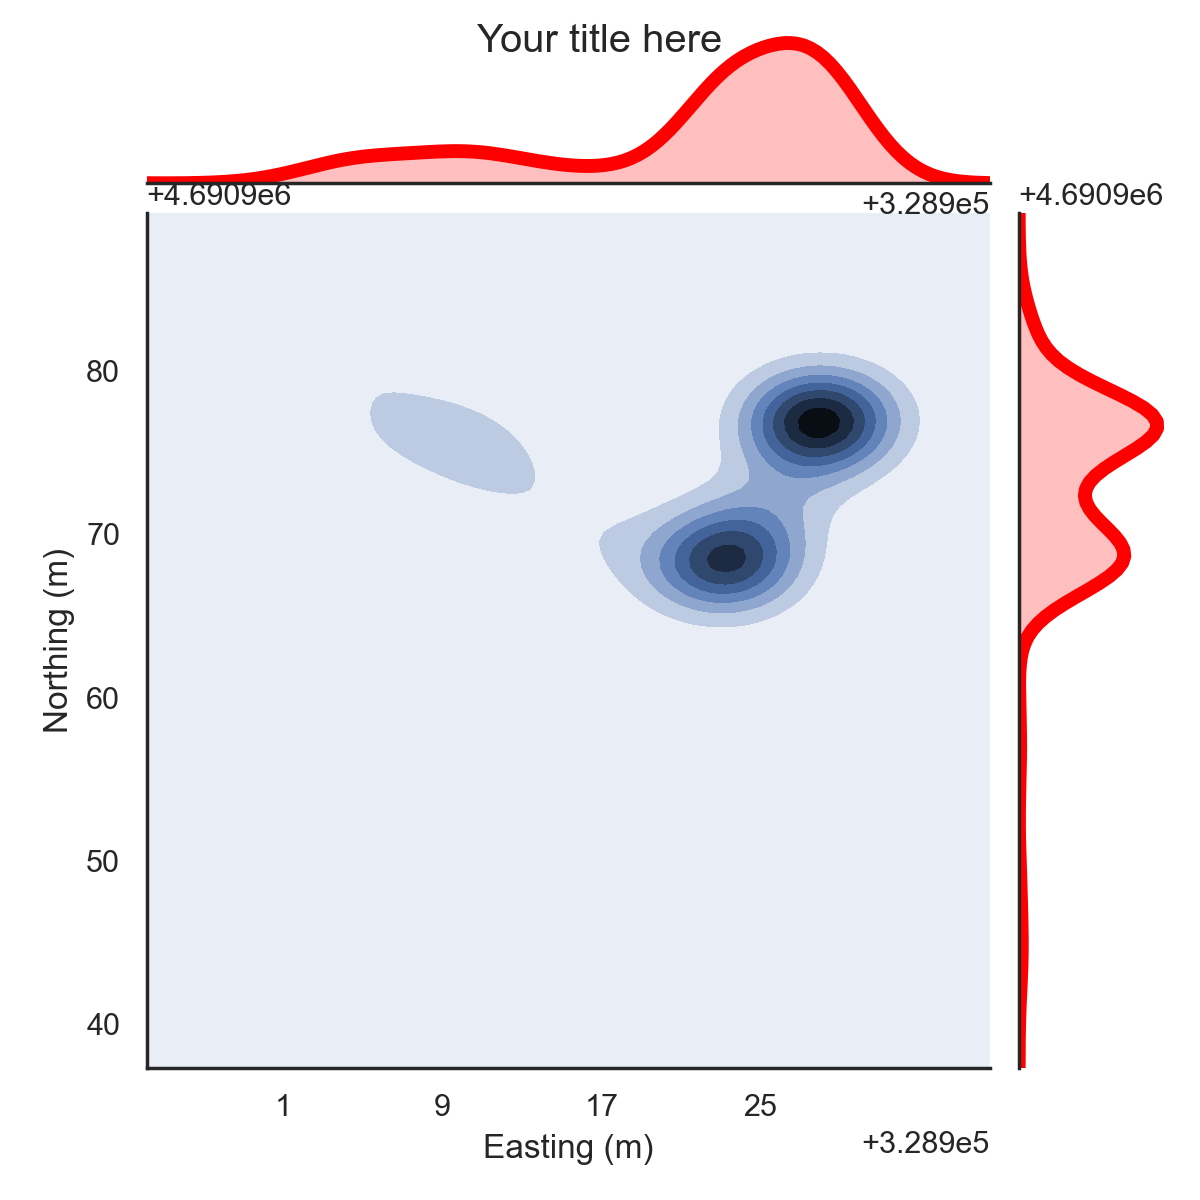

In [97]:
# 2 dimensional KDE of locations while remaining stationary
sns.set(style="white", color_codes=True)
plt.ylim(dataStat['utm_easting'].min(), dataStat['utm_easting'].max() + 1000)
ax = sns.jointplot(
    x=dataStat["utm_easting"],
    y=dataStat["utm_northing"],
    kind='kde',
    marginal_kws={'lw':5,
                 'color':'red'})
ax.set_axis_labels('Easting (m)', 'Northing (m)')
ax.ax_joint.set_xticks(np.arange(int(dataStat["utm_easting"].min()), int(dataStat["utm_easting"].max()), 8))

<IPython.core.display.Javascript object>


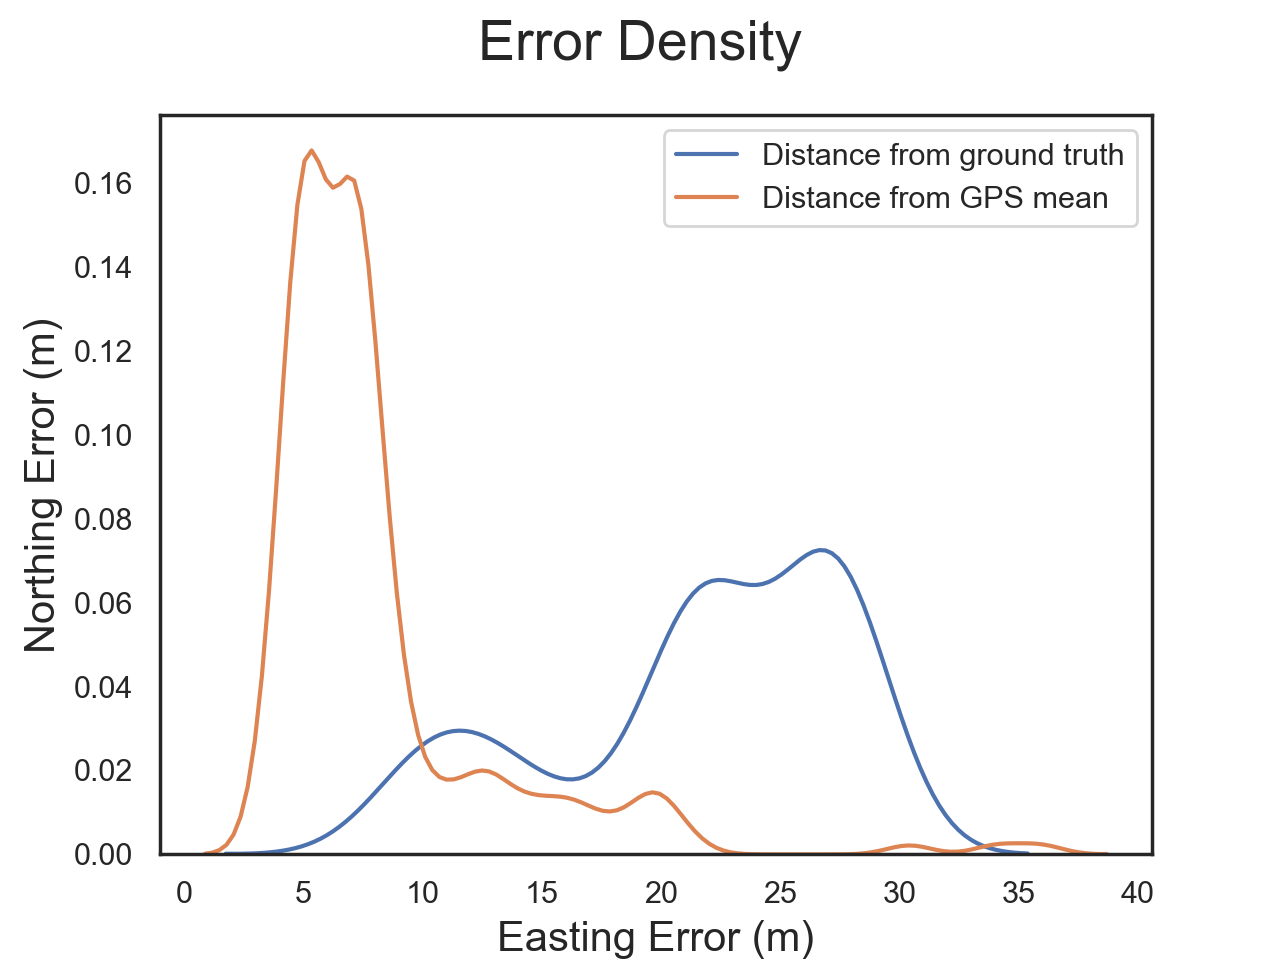

Text(0, 0.5, 'Density')

In [136]:
fig2 = plt.figure()
ax2 = fig2.gca()
sns.kdeplot(dataStat['error_abs'], label='Distance from ground truth')
fig2.suptitle('Error Density', fontsize=20)
ax2.set_xlabel('Error (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15) 
# Precision
sns.kdeplot(dataStat['error_precision'], label='Distance from GPS mean')
ax2.set_xlabel('Error (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15) 

<IPython.core.display.Javascript object>


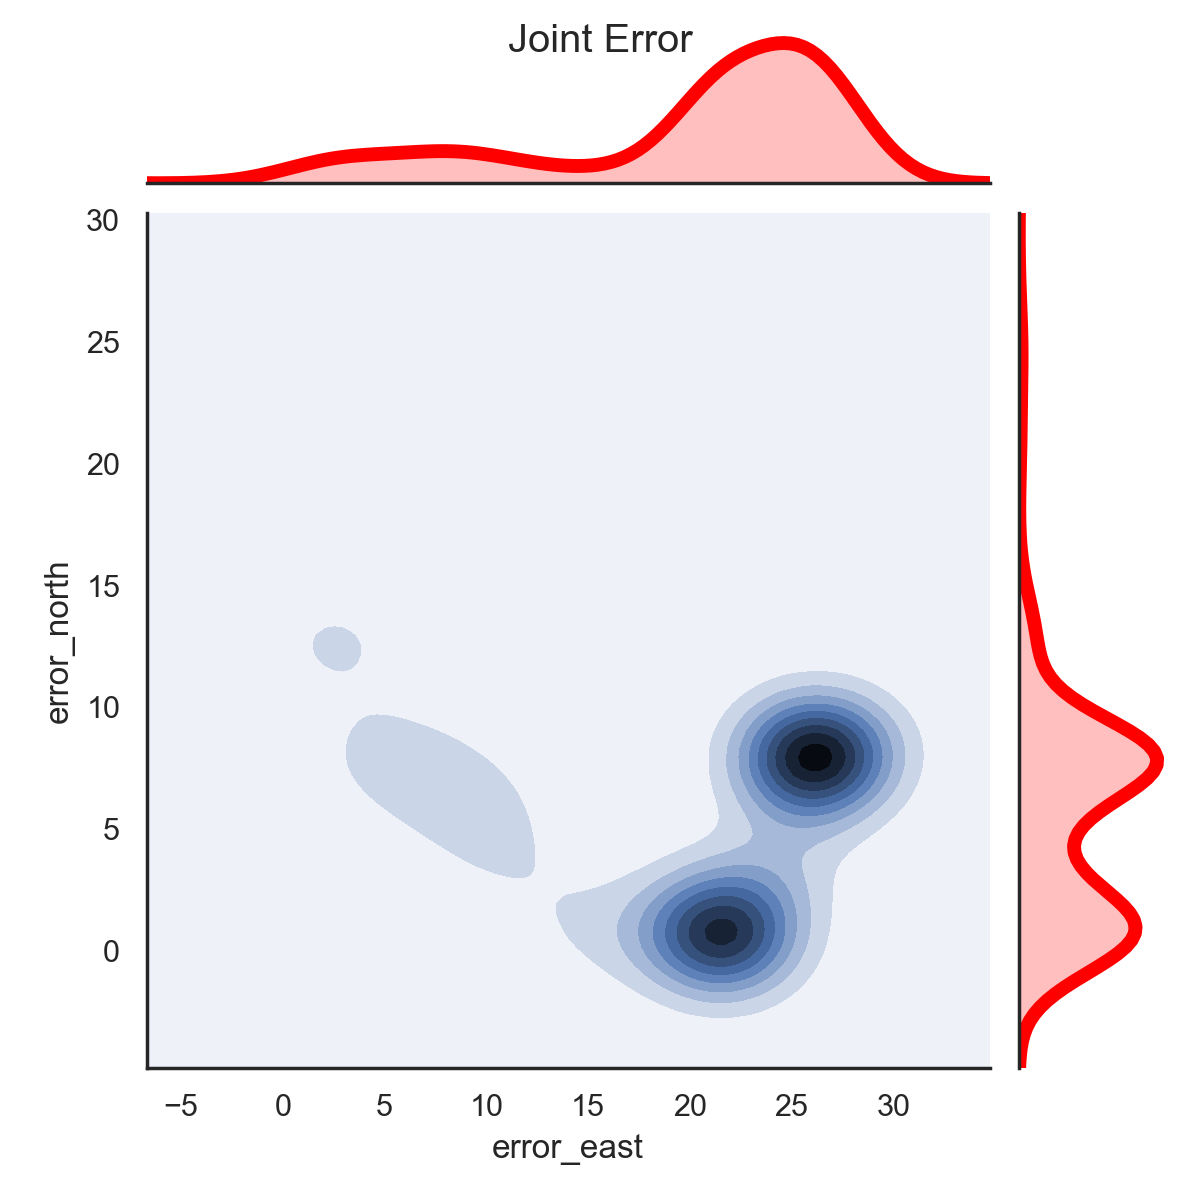

Text(63.125, 0.5, 'Northing Error (m)')

In [137]:
# 2 dimensional KDE
sns.set(style="white", color_codes=True)
ax = sns.jointplot(
    x=dataStat["error_east"],
    y=dataStat["error_north"],
    kind='kde',
    marginal_kws={'lw':5,
                 'color':'red'})
ax.fig.suptitle('Joint Error')
ax2.set_xlabel('Easting Error (m)', fontsize=15)
ax2.set_ylabel('Northing Error (m)', fontsize=15) 

In [92]:
# Print summary statistics
pd.set_option("display.width", 250)
d = dataStat.describe()[['utm_easting','utm_northing','error_abs']]
d.columns = ['Easting (m)', 'Northing (m)', 'Error (m)']
d

Easting (m)        Northing (m)         Error (m)
count     200.000000000000  2.000000000000e+02  200.000000000000
mean   328921.645937499998  4.690973090000e+06   21.573843797745
std         7.754869163333  5.593822867356e+00    6.040981155849
min    328901.312500000000  4.690943500000e+06    8.394263294330
25%    328918.867187500000  4.690968500000e+06   18.728832146299
50%    328923.500000000000  4.690975000000e+06   21.694261914152
75%    328927.687500000000  4.690977000000e+06   27.106639523462
max    328929.343750000000  4.690983500000e+06   28.717320149480

<IPython.core.display.Javascript object>


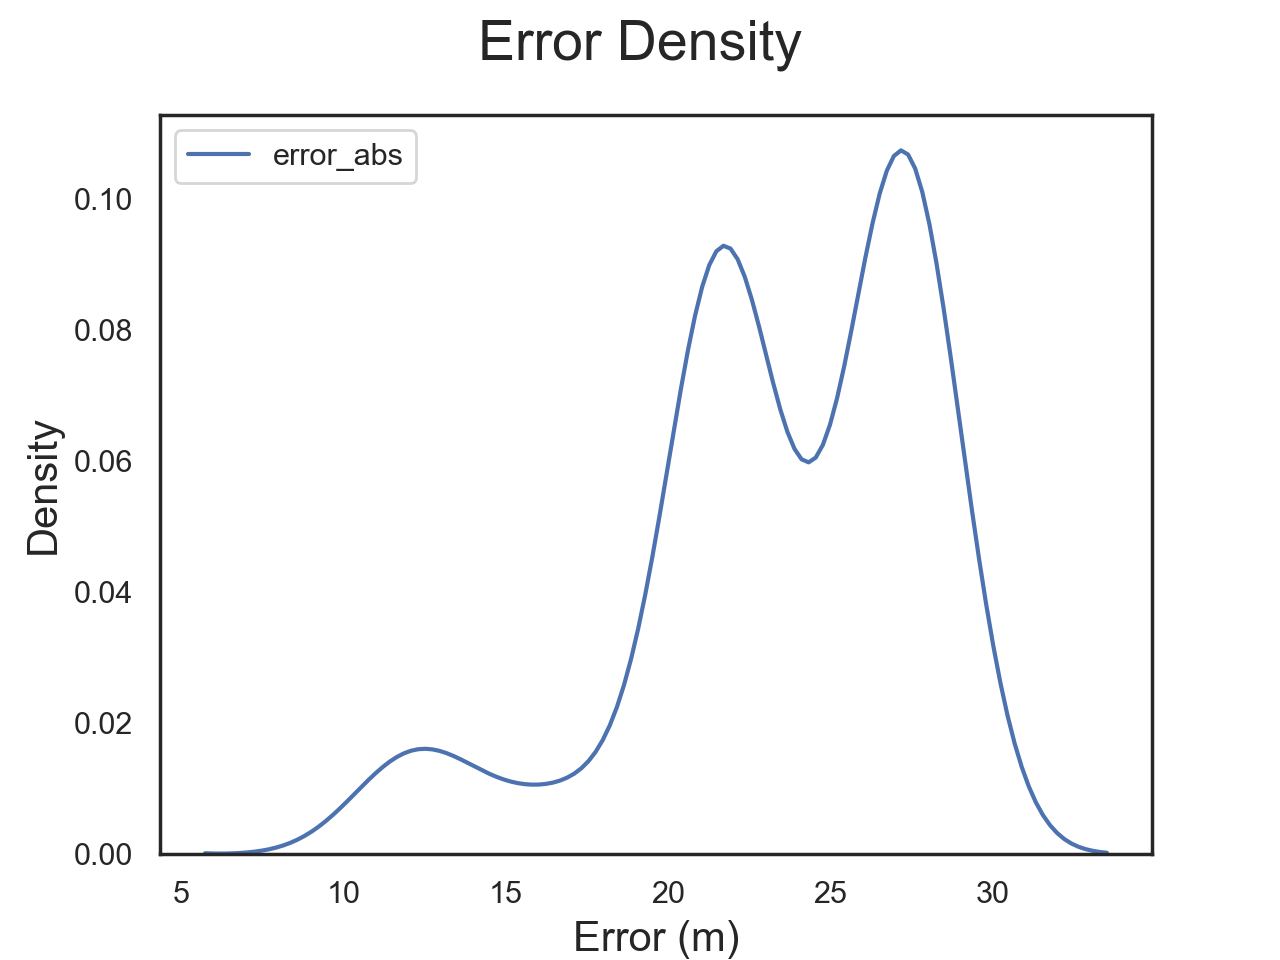

Text(0, 0.5, 'Density')

In [103]:
# Remove high value initial outliers
rm_outliers = dataStat[dataStat['time_elapsed'] > 120]
fig2 = plt.figure()
ax2 = fig2.gca()
sns.kdeplot(rm_outliers['error_abs'])
fig2.suptitle('Error Density', fontsize=20)
ax2.set_xlabel('Error (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15) 

In [140]:
# Calculating drifting mean over time
easting = np.array(dataStat['utm_easting'])
northing = np.array(dataStat['utm_northing'])
mean_east = []
mean_north = []
for index in range(1, len(easting)):
    mean_east.append(np.mean(easting[:index]))
    mean_north.append(np.mean(northing[:index]))
red = Color("red")
colors = list(red.range_to(Color("green"),len(mean_east)))

<IPython.core.display.Javascript object>


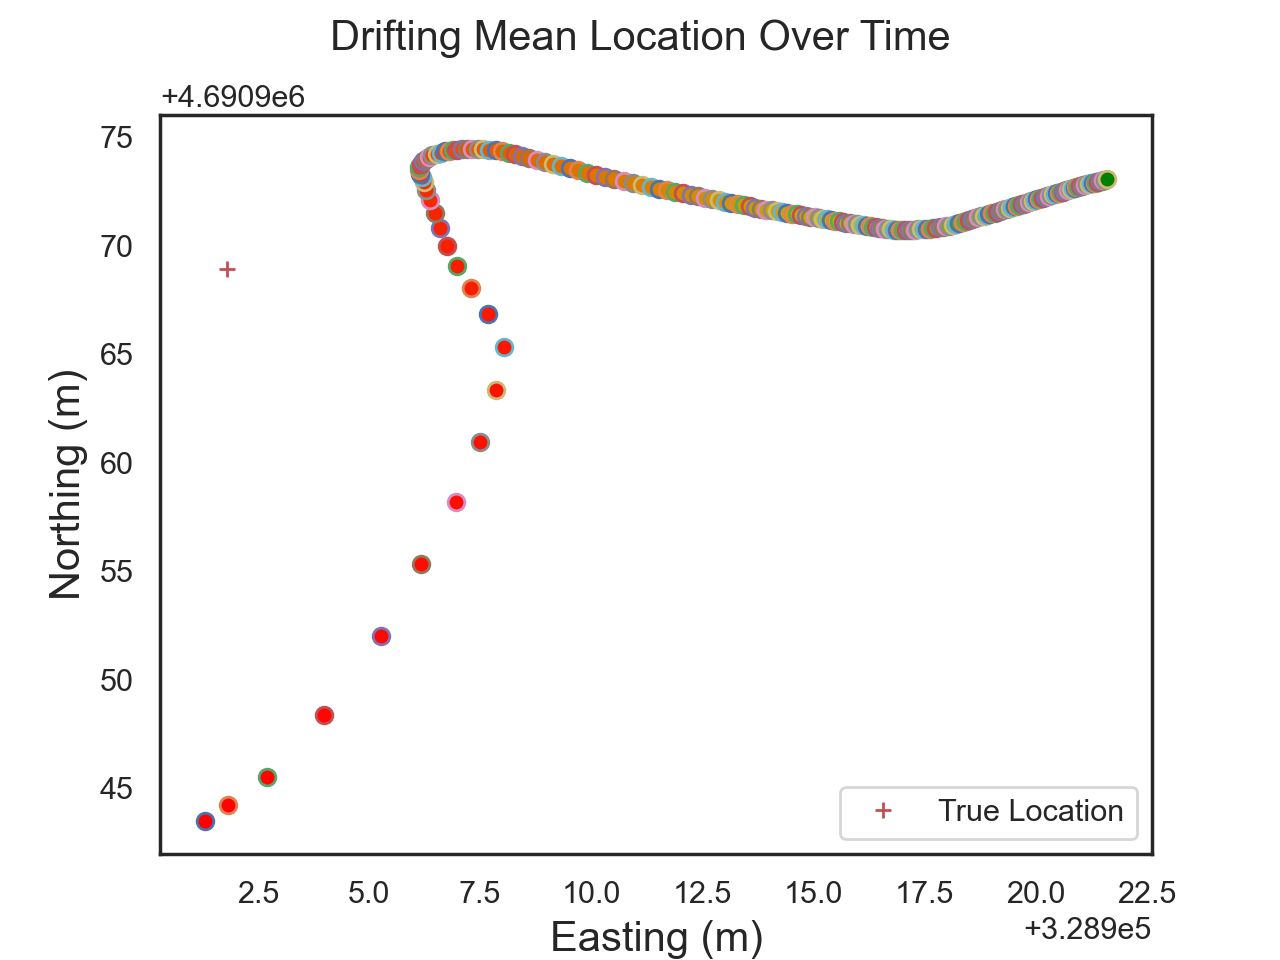

In [145]:
# Northing error over time
fig5 = plt.figure()
ax5 = fig5.gca()
for x in range(len(mean_east)):
    plt.plot(mean_east[x], mean_north[x], marker='o', markerfacecolor=colors[x].hex)
plt.plot(true_utm[0], true_utm[1], 'r+', label='True Location')
fig4.suptitle('Northing Error Over Time', fontsize=20)
ax5.set_xlabel('Easting (m)', fontsize=15)
ax5.set_ylabel('Northing (m)', fontsize=15)
fig5.suptitle('Drifting Mean Location Over Time', fontsize=15)
ax5.legend()

In [11]:
dataStat.describe()

Time        header.seq   header.stamp.secs  \
count  1.990000000000e+02  199.000000000000  1.990000000000e+02   
mean   1.613674513726e+09  100.000000000000  1.613674513221e+09   
std    2.118488215720e+01   57.590508477237  2.119132080734e+01   
min    1.613674477566e+09    1.000000000000  1.613674477000e+09   
25%    1.613674495496e+09   50.500000000000  1.613674495000e+09   
50%    1.613674513425e+09  100.000000000000  1.613674513000e+09   
75%    1.613674531979e+09  149.500000000000  1.613674531500e+09   
max    1.613674550016e+09  199.000000000000  1.613674550000e+09   

       header.stamp.nsecs  header.frame_id               lat  \
count  1.990000000000e+02            199.0  199.000000000000   
mean   4.965176913065e+08              1.0   42.352215196619   
std    2.892756629043e+08              0.0    0.000050832270   
min    4.196100000000e+04              1.0   42.351943969727   
25%    2.455950970000e+08              1.0   42.352176666260   
50%    4.950850000000e+08              1.0   42.352233886719   
75%    7.520880695000e+08              1.0   42.352252960205   
max    9.893550870000e+08              1.0   42.352306365967   

                    lon          altitude          utm_easting  \
count  199.000000000000  199.000000000000     199.000000000000   
mean   -71.077175504598   22.364321622417  328921.630810301518   
std      0.000094147865    8.155328118518       7.771468678520   
min    -71.077415466309   14.800000190735  328901.312500000000   
25%    -71.077209472656   18.000000000000  328918.765625000000   
50%    -71.077148437500   18.299999237061  328923.500000000000   
75%    -71.077102661133   27.799999237061  328927.687500000000   
max    -71.077079772949   63.500000000000  328929.343750000000   

             utm_northing  num_sats              hdop   zone  \
count  1.990000000000e+02     199.0  199.000000000000  199.0   
mean   4.690973100503e+06       4.0    4.502512560418   19.0   
std    5.605953702799e+00       0.0    0.078132929112    0.0   
min    4.690943500000e+06       4.0    4.400000095367   19.0   
25%    4.690968500000e+06       4.0    4.400000095367   19.0   
50%    4.690975000000e+06       4.0    4.500000000000   19.0   
75%    4.690977000000e+06       4.0    4.599999904633   19.0   
max    4.690983500000e+06       4.0    4.599999904633   19.0   

              error_loc         error_abs   error_precision        error_east  \
count  199.000000000000  199.000000000000  199.000000000000  199.000000000000   
mean     8.346048338440   21.566979519335    8.177931759514   19.825810301510   
std      6.855330677912    6.055434950338    4.960454004535    7.758639773885   
min      0.089436991168    8.394263294330    3.683123154854    0.497499999998   
25%      0.676910452367   18.619560246232    5.116538428410   16.955625000002   
50%      9.873492156725   21.694261914152    7.203441591306   21.690000000002   
75%     10.483767145617   27.106639523462    8.503507503072   25.877500000002   
max     33.283354764802   28.717320149480   35.902973170706   27.533750000002   

            error_north         error_alt      time_elapsed  
count  199.000000000000  199.000000000000  199.000000000000  
mean     5.409698492581   15.658721622417  362.211055276382  
std      4.415315620775    8.155328118518  211.913208073380  
min      0.070000000298    8.094400190735    0.000000000000  
25%      0.929999999702   11.294400000000  180.000000000000  
50%      6.570000000298   11.594399237061  360.000000000000  
75%      8.070000000298   21.094399237061  545.000000000000  
max     25.429999999702   56.794400000000  730.000000000000